In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import hilbert, butter, filtfilt, freqz, lfilter, sosfilt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from sklearn.linear_model import Lasso
import itertools
import os
import h5py

from scipy.linalg import toeplitz, circulant
from scipy.io import loadmat
import numpy as np
from scipy.interpolate import griddata

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import plotly.graph_objects as go
from torchsummary import summary
from ipywidgets import interactive, Layout, FloatSlider
import re
# # Manually run garbage collection
! nvidia-smi
device = 'cuda:2'


# def butter_bandpass(lowcut, highcut, fs, order=5):
#     b, a = butter(order, [lowcut, highcut], fs=fs, btype='band')
#     return b, a

# def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
#     b, a = butter_bandpass(lowcut, highcut, fs, order=order)
#     y = filtfilt(b, a, data, axis=1)
#     return y

%matplotlib inline

Mon Mar 10 22:06:09 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti      On | 00000000:05:00.0 Off |                  N/A |
| 23%   41C    P8               12W / 250W|    150MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Rapid Radiator

In [2]:
### All helpers function stored here
rtrans  = 30   
def get_psf(x):
    mu = abs(np.fft.fft(hilbert_torch(x))).T.mean(-1)
    psf = np.fft.fftshift(np.fft.ifft(mu))
    return psf

# the wiener conv solve the deconvolution for x given 
# the PSF constructed as matrix Ar (real) & Ai (imaginary)
# the output is a complex number solution of the deconvolved signal
def wiener_conv(y,h,method='LASSO',noise_estimate=0,reg_params=1e-6):
    # need to normalize the data first
    # y is all real data

    if method == 'LASSO':
        kernel  = np.fft.fftshift(h)
        G       = circulant(kernel)

        yinp    = y.numpy()
        yinpmax = yinp.max(0)
        yinp    = yinp / yinpmax
        solReal =  Lasso(alpha=reg_params,max_iter=100000).fit(G.real,yinp).coef_.T * yinpmax

        yinp    = y.numpy()
        yinpmax = yinp.max(0)
        yinp    = yinp / yinpmax
        solImag =  Lasso(alpha=reg_params,max_iter=100000).fit(G.imag,yinp).coef_.T * yinpmax

        sol = solReal + 1j*solImag

        return sol.T

        
    if method == 'FREQ':

        denum   = (abs(np.fft.fft(h))**2 + reg_params * ( abs(np.fft.fft(noise_estimate))**2 / abs(np.fft.fft(h) + 1e-12)**2)) 

        M       = np.fft.fft(h).conj() / denum
        PAr     = np.fft.ifftshift(np.fft.ifft( (np.fft.fft(y.T) * M) ),1)

        final_result = PAr

    if method == "TIKHONOV":
        y_raw = y.clone()
        y_max = y.max(0).values
        y     = y / (y_max)
        psf_r = np.real(np.fft.fftshift(h))
        psf_i = np.imag(np.fft.fftshift(h))

        # construct shif matrix
        Ar = toeplitz(psf_r,psf_r)
        Ai = toeplitz(psf_i,psf_i)

        x_hat_r = np.linalg.inv(Ar.T @ Ar + np.eye(Ar.shape[0])*reg_params) @ Ar.T @ y.numpy()
        x_hat_i = np.linalg.inv(Ai.T @ Ai + np.eye(Ai.shape[0])*reg_params) @ Ai.T @ y.numpy()

        x_hat = x_hat_r + 1j*x_hat_i

        x_hat = (x_hat.T)
        final_result = x_hat * y_max.unsqueeze(-1).numpy()
    
    # final_result = hilbert(final_result)

    return final_result

# The rotate matrix rotate the initial_vector to the target_vector
# It outputs the transformation matrix which we will use to rotate the imaging
# plane as well
def rot_matrix_arb(initial_vector,
                   target_vector=torch.tensor([0,0,rtrans],dtype=torch.float).to(device)):
    # Calculate the rotation axis (cross product) and normalize it
    rotation_axis = torch.cross(initial_vector.squeeze(), target_vector.squeeze(),dim=0)
    rotation_axis = rotation_axis / torch.norm(rotation_axis)

    # Calculate the rotation angle (in radians)
    rotation_angle = torch.acos(
        torch.dot(initial_vector, target_vector) /
        (torch.norm(initial_vector) * torch.norm(target_vector))
    )

    # Construct the rotation matrix using the axis-angle formula
    K = torch.tensor([
        [0, -rotation_axis[2], rotation_axis[1]],
        [rotation_axis[2], 0, -rotation_axis[0]],
        [-rotation_axis[1], rotation_axis[0], 0]
    ]).to(device)

    # Identity matrix
    I = torch.eye(3).to(device)

    # Rotation matrix formula: R = I + sin(angle) * K + (1 - cos(angle)) * K^2
    # R_matrix = I + torch.sin(rotation_angle) * K + (1 - torch.cos(rotation_angle)) * (K @ K)
    # Rodrigues's First Formula
    rrmat = torch.cos(rotation_angle) * I + torch.sin(rotation_angle) * K + (1 - torch.cos(rotation_angle)) * (rotation_axis.unsqueeze(1) @ rotation_axis.unsqueeze(1).T)

    return rrmat


def rotate_matrix_twice(initial_vector):
    # rotate to the center
    target_vector = torch.tensor([0,0,rtrans],dtype=torch.float).to(device)

    # Calculate the rotation axis (cross product) and normalize it
    rotation_axis = torch.cross(initial_vector.squeeze(), target_vector.squeeze(),dim=0)
    rotation_axis = rotation_axis / torch.norm(rotation_axis)

    # Calculate the rotation angle (in radians)
    rotation_angle = torch.acos(
        torch.dot(initial_vector, target_vector) /
        (torch.norm(initial_vector) * torch.norm(target_vector))
    )

    # Construct the rotation matrix using the axis-angle formula
    K = torch.tensor([
        [0, -rotation_axis[2], rotation_axis[1]],
        [rotation_axis[2], 0, -rotation_axis[0]],
        [-rotation_axis[1], rotation_axis[0], 0]
    ]).to(device)

    # Identity matrix
    I = torch.eye(3).to(device)

    # Rotation matrix formula: R = I + sin(angle) * K + (1 - cos(angle)) * K^2
    # R_matrix = I + torch.sin(rotation_angle) * K + (1 - torch.cos(rotation_angle)) * (K @ K)
    # Rodrigues's First Formula
    rrtocenter = torch.cos(rotation_angle) * I + torch.sin(rotation_angle) * K + (1 - torch.cos(rotation_angle)) * (rotation_axis.unsqueeze(1) @ rotation_axis.unsqueeze(1).T)

    # rotation to align  the xy coordinates
    angle_ = - torch.arctan(initial_vector[1]/initial_vector[0])
    rrxy = torch.tensor([
        [torch.cos(angle_)  ,-torch.sin(angle_)  ,0],
        [torch.sin(angle_)  , torch.cos(angle_)  ,0],
        [0                  , 0                  ,1]
    ]).to(device)


    return rrxy @ rrtocenter

def get_directivity(idx):
    # the rotate matrix twice 
    # 1. rotate the whole field directly [0, 0, rtrans]
    # 2. rotate the whole field depending on the orientation of the element, i.e., make it normal to x and y
    rr      = rotate_matrix_twice(sensor_pos[:, idx]) @ torch.vstack([rix.ravel(),riy.ravel(),riz.ravel()]) # operation in m

    # get directivity, rotri: rotated coordinate ri
    rotrix  = (rr[0].reshape(imsz,imsz,imsz))            * 1e-3           # in m
    rotriy  = (rr[1].reshape(imsz,imsz,imsz))            * 1e-3           # in m
    rotriz  = (rr[2].reshape(imsz,imsz,imsz) - rtrans)   * 1e-3           # in m, transpose to 0



    # from Damien Garcia's SIMUS3 Paper
    k           = 2*torch.pi*Fc/(cPA)
    rrr         = torch.sqrt(rotrix.square() + rotriy.square()+ rotriz.square())
    sinphi      = rotriy                                        / torch.sqrt(rotrix.square() + rotriy.square())
    cosphi      = rotrix                                        / torch.sqrt(rotrix.square() + rotriy.square())
    sintheta    = torch.sqrt(rotrix.square() + rotriy.square()) / rrr

    # torch's sinc is normalized: sin(pi x) /( pi x)
    # we want it unnormalized
    Dx = torch.sinc(k * b    * cosphi * sintheta / torch.pi)
    Dy = torch.sinc(k * beta * sinphi * sintheta / torch.pi)

    # from Cobbold's book
    # l_lambda    = cPA/(2*torch.pi*Fc)
    # sintheta    = rotrix / torch.sqrt(rotrix.square() + rotriy.square()+ rotriz.square())
    # sinphi      = rotriy / torch.sqrt(rotrix.square() + rotriy.square()+ rotriz.square())
    # W           = 2*b         
    # H           = 2*beta

    # # Sinc in pytorch is normalized
    # Dx = torch.sinc(W *  sintheta /(l_lambda * torch.pi))
    # Dy = torch.sinc(H *  sinphi   /(l_lambda * torch.pi))

    #D = torch.sqrt(Dx.abs().square() + Dy.abs().square())
    D = Dx * Dy

    return D

def hilbert_torch(signal, dim=-1):
    """
    Computes the Hilbert transform of a multi-dimensional signal using the Fast Fourier Transform (FFT).
    This implementation mimics MATLAB's hilbert function.

    Args:
        signal (torch.Tensor): The input n-dimensional tensor (signal) to transform.
        dim (int): The dimension along which to compute the Hilbert transform.

    Returns:
        torch.Tensor: The complex-valued Hilbert transform (analytic signal) of the input signal.
    """
    # Ensure the input is a tensor
    if not isinstance(signal, torch.Tensor):
        raise ValueError("Input must be a PyTorch tensor.")

    # Get the shape of the input tensor
    shape = signal.shape

    # Move the tensor to GPU if available
    device = signal.device
    N = signal.size(dim)

    # Compute the FFT along the specified dimension
    transforms = torch.fft.fft(signal, dim=dim)

    # Create a mask to apply to the FFT results
    mask = torch.zeros(N, dtype=torch.complex64, device=device)
    mask[0] = 1  # DC component remains unchanged
    mask[1:N//2] = 2  # Double the amplitude for positive frequencies
    if N % 2 == 0:
        mask[N//2] = 1  # Include the Nyquist frequency if even

    # Apply the mask to the FFT of the signal
    transforms = transforms * mask

    # Compute the inverse FFT to get the Hilbert transform (analytic signal)
    hilbert_signal = torch.fft.ifft(transforms, dim=dim)

    return hilbert_signal

def PreSVDFilter(dat,ths):
    nframes = dat.shape[-1]
    navg = dat.shape[0]
    nsensor = dat.shape[-2]
    dat = dat.transpose(3,0,1,2)
    recfinal = np.zeros_like(dat)
    for i in range(nsensor):
        test = dat[...,i]
        test_flat = test.reshape(nframes * navg,-1).T
        [u,s,v] = np.linalg.svd(test_flat)
        s[ths:] = 0 # hard threshold
        rec = (u[:,:len(s)] @ np.diag(s) @ v).T.reshape(nframes,navg,-1)
        recfinal[...,i] = rec

    recfinal = recfinal.transpose(1,2,3,0)

    return recfinal
def PostSVDFilter(dat,ths):
    [u,s,v] = np.linalg.svd(dat.cpu(),'econ')
    s[:ths] = 0 # hard threshold
    rec = (u[:,:len(s)] @ np.diag(s) @ v)
    return rec

from curvelops import FDCT2D

def trace_filter(inp,ths):
    CurvOp = FDCT2D(inp.shape)

    y = CurvOp @ inp
    y[y < ths] = 0
    rec = CurvOp.H @ y
    return rec

def process_sensor_PA(idx_rcv,datPAraw,sensor_pos_local,with_directivity=False):
    # Receive
    dPos_rcv = sensor_pos_local[:, idx_rcv]
    phys_dist_rcv = torch.sqrt((rix - dPos_rcv[0]) ** 2 + (riy - dPos_rcv[1]) ** 2 + (riz - dPos_rcv[2]) ** 2)

    time_points_distPA = ((phys_dist_rcv) * 1e-3 / cPA) * Fs - start_time_PA
    
    linear_factor = (time_points_distPA -  torch.floor(time_points_distPA))
    data_slicePA = (datPAraw[idx_rcv, torch.floor(time_points_distPA).to(torch.int32)] 
                    + linear_factor*(
                        datPAraw[idx_rcv, torch.ceil(time_points_distPA).to(torch.int32)]
                        - datPAraw[idx_rcv, torch.floor(time_points_distPA).to(torch.int32)]
                    ))
    
    if with_directivity:
        D = get_directivity(idx_rcv)
        return D * data_slicePA
    else:
        return data_slicePA 

def fk_filter(test):
    ntime = test.shape[0]
    nsensor = test.shape[1]
    nseg = 4
    #
    test = test.reshape(ntime,nseg,-1).permute(1,2,0)
    testft = torch.fft.fftshift(torch.fft.fft2(test),dim=(1,2))
    testft[:,32,:] = 0

    rec = torch.fft.ifft2(torch.fft.ifftshift(testft,dim=(1,2))).permute(2,0,1).reshape(ntime,nsensor).real

    return rec

# normalize mse
def mse(A,B):
    A = (A - A.min()) / (A.max() - A.min())
    B = (B - B.min()) / (B.max() - B.min())
    return nn.MSELoss()(A,B)

def depthImage2(volume,idx,isShow=False):

    # Step 1: Project depth data to create a depth map
    depth_map = np.argmax(volume, axis=2)

    # Step 2: Normalize the depth data for color mapping
    depth_normalized = (depth_map - np.min(depth_map)) / (np.max(depth_map) - np.min(depth_map))

    # Step 3: Create an intensity map for coloring
    # Use the maximum intensity along the depth (z-axis) for each (x, y) location
    intensity_map = np.max(volume, axis=2)

    # Normalize intensity values to range [0, 1]
    intensity_normalized = (intensity_map - np.min(intensity_map)) / (np.max(intensity_map) - np.min(intensity_map))

    # Step 5: Apply the 'inferno' colormap to the depth map using plt.get_cmap
    colormap = plt.get_cmap('inferno')
    depth_colored = colormap(depth_normalized)

    # Step 6: Scale the colormap by intensity (for darkness effect)
    depth_colored[..., :3] = depth_colored[..., :3] * intensity_normalized[..., np.newaxis]  # Apply intensity to RGB channels

    return depth_colored

#     # Step 7: Display the result with 2D gradation
#     fig, ax = plt.subplots()
#     depth_colored = np.rot90(depth_colored)
# #     depth_colored = np.flipud(depth_colored)
#     im = ax.imshow(depth_colored,cmap='inferno')

#     # Add the colorbar with the same 'inferno' colormap
#     cbar = fig.colorbar(im, ax=ax, cmap='inferno')  # Explicitly set the colormap for the colorbar
#     cbar.set_label('Depth (mm), Surface @ 0 mm ')  # Customize the label as needed
#     cbar.set_ticks(np.linspace(0,1,5))  # Set the tick positions
#     cbar.set_ticklabels([f"{x:.1f}" for x in np.linspace(-r,-0.45,5)])  # Set the tick positions minus offset of surface location by US
#     # Display the plot
#     # ax.axis('off')  # Turn off axis
#     plt.xticks(np.linspace(0,imsz,5),[f"{x:.1f}" for x in np.linspace(-r,r,5)])
#     plt.yticks(np.linspace(0,imsz,5),[f"{x:.1f}" for x in np.linspace(r,-r,5)])

#     ax.text(0.95, 0.05, f"{(idx * (1/20)):.2f} s", color='white', fontsize=12, ha='right', va='bottom',
#             transform=ax.transAxes, bbox=dict(facecolor='black', alpha=0.5))
    
    # if isShow:
    #     plt.show()
    # else:
    #     plt.savefig(os.path.expanduser(f'~/Documents/images/{idx}.png'),bbox_inches='tight')
    #     plt.close()


def depthImage(volume,idx,isShow=False):

    # Step 1: Project depth data to create a depth map
    depth_map = np.argmax(volume, axis=2)

    # Step 2: Normalize the depth data for color mapping
    depth_normalized = (depth_map - np.min(depth_map)) / (np.max(depth_map) - np.min(depth_map))

    # Step 3: Create an intensity map for coloring
    # Use the maximum intensity along the depth (z-axis) for each (x, y) location
    intensity_map = np.max(volume, axis=2)

    # Normalize intensity values to range [0, 1]
    intensity_normalized = (intensity_map - np.min(intensity_map)) / (np.max(intensity_map) - np.min(intensity_map))

    # Step 5: Apply the 'inferno' colormap to the depth map using plt.get_cmap
    colormap = plt.get_cmap('inferno')
    depth_colored = colormap(depth_normalized)

    # Step 6: Scale the colormap by intensity (for darkness effect)
    depth_colored[..., :3] = depth_colored[..., :3] * intensity_normalized[..., np.newaxis]  # Apply intensity to RGB channels

    # Step 7: Display the result with 2D gradation
    fig, ax = plt.subplots()
    depth_colored = np.rot90(depth_colored)
#     depth_colored = np.flipud(depth_colored)
    im = ax.imshow(depth_colored,cmap='inferno')

    # Add the colorbar with the same 'inferno' colormap
    cbar = fig.colorbar(im, ax=ax, cmap='inferno')  # Explicitly set the colormap for the colorbar
    cbar.set_label('Depth (mm), Surface @ 0 mm ')  # Customize the label as needed
    cbar.set_ticks(np.linspace(0,1,5))  # Set the tick positions
    cbar.set_ticklabels([f"{x:.1f}" for x in np.linspace(-r,-0.45,5)])  # Set the tick positions minus offset of surface location by US
    # Display the plot
    # ax.axis('off')  # Turn off axis
    plt.xticks(np.linspace(0,imsz,5),[f"{x:.1f}" for x in np.linspace(-r,r,5)])
    plt.yticks(np.linspace(0,imsz,5),[f"{x:.1f}" for x in np.linspace(r,-r,5)])

    ax.text(0.95, 0.05, f"{(idx * (1/20)):.2f} s", color='white', fontsize=12, ha='right', va='bottom',
            transform=ax.transAxes, bbox=dict(facecolor='black', alpha=0.5))
    
    if isShow:
        plt.show()
    else:
        plt.savefig(os.path.expanduser(f'~/Documents/images/{idx}.png'),bbox_inches='tight')
        plt.close()

In [3]:
# get super psf
def get_abs_ft(path="/mnt/Personal_Folders/Eka/PAT/22102024.mat",nus=28,npa=30,nframes=6):
    sensor_data     = loadmat(path)['RcvData'][0][0]
    sensor_data     = np.reshape(sensor_data,(nus+npa,3072,256,nframes))[:,1144:1400,:,:].transpose(1, 2, 3, 0).reshape(256,-1)
    sensor_data     = hilbert(sensor_data,axis=0)
    ft              = abs(np.fft.fft(sensor_data,axis=0)).mean(1)
    return ft

ft1 = get_abs_ft("/mnt/Personal_Folders/Eka/PAT/Others/22102024.mat",28,30,6)
ft2 = get_abs_ft("/mnt/Personal_Folders/Eka/PAT/241002/LeafVessels2.mat",28,30,6)
ft3 = get_abs_ft("/mnt/Personal_Folders/Eka/PAT/07122024/USPA/matlab3.mat",28,75,4)
ft4 = get_abs_ft("/mnt/Personal_Folders/Eka/PAT/07122024/USPA/matlab4.mat",28,75,4)
ft5 = get_abs_ft("/mnt/Personal_Folders/Eka/PAT/07122024/USPA/matlab5.mat",28,75,4)
ft6 = get_abs_ft("/mnt/Personal_Folders/Eka/PAT/07122024/USPA/matlab6.mat",28,75,4)
ft7 = get_abs_ft("/mnt/Personal_Folders/Eka/PAT/07122024/RealTimePA/matlab7.mat", 0,75,4)
ftall = np.array([ft1,ft2,ft3,ft4,ft5,ft6,ft7]).mean(0)
ftall = ftall / ftall.max()
psf = np.fft.ifftshift(np.fft.ifft(ftall))
psf = psf / abs(psf).max()

In [4]:
Fc      = 15.625e6                            
Fs      = 4*Fc                       
ntime   = 3072
dt      = 1/Fs
rtrans  = 30            # mm
b       = 1e-3          # m, half width trans
beta    = 1e-3          # m, half height trans
nframes = 4
# nframes = 6
navg    = 30

imsz    = 128
r       = 1.5 # in mm

cUS     = 1480 
cPA     = 1475 #1475 --> this is supposed to be 1480~

sensor_pos      = loadmat("./dataset/echigo/TransducerParameter.mat")['Pos'].T * 1e3 # make mm
sensor_pos      = torch.tensor(sensor_pos,dtype=torch.float).to(device)
# sensor_data     = loadmat("/mnt/Personal_Folders/Eka/PAT/22102024.mat")['RcvData'][0][0]
# sensor_data     = loadmat("/mnt/Personal_Folders/Eka/PAT/241002/LeafVessels2.mat")['RcvData'][0][0]
sensor_data = loadmat("/mnt/Personal_Folders/Eka/PAT/07122024/USPA/matlab4.mat")['RcvData'][0][0]
# sensor_data = loadmat("/mnt/Personal_Folders/Eka/PAT/07122024/RealTimePA/matlab7.mat")['RcvData'][0][0]
TXUS            = 28
TXPA            = 75
# TXPA            = 30

dat             = np.reshape(sensor_data,(TXUS+TXPA,ntime,256,nframes))
AlldatPA_raw    = ((dat[TXUS:,:,:,:])) # take only PA portion
AlldatPA_raw    = AlldatPA_raw/ AlldatPA_raw.max()


# AlldatUS_raw    = ((dat[:TXUS,:,:,:])) # take only US portion at one frame
# AlldatUS_raw    = AlldatUS_raw / AlldatUS_raw.max()

nsensor         = 256

UseTXElements   = torch.tensor([4,17,30,43,53,65,77,89,107,118,129,140,151,160,169,178,182,190,198,206,215,221,227,233,241,246,251,256], dtype=torch.float32) - 1

del sensor_data, dat


d = (3*(r**2))**0.5
# PA
start_time_PA  = np.floor((((sensor_pos.cpu().numpy()[:,0]**2).sum())**0.5 - d) * 1e-3 * Fs / cPA).astype(int) - 10 - 7
end_time_PA    = np.ceil((((sensor_pos.cpu().numpy()[:,0]**2).sum())**0.5 + d) * 1e-3 * Fs / cPA).astype(int) + 11 + 7

# reduce the dimension
AlldatPA = AlldatPA_raw.copy()[:,start_time_PA:end_time_PA,:,:]
AlldatPA = AlldatPA / AlldatPA.max()

# get psf
datPA       = torch.tensor((AlldatPA[0,:,:,0]).T,dtype=torch.float)
datPA       = fk_filter(datPA.T).T
noisefloor  = np.random.normal(0,1,len(psf)) * 1e-3

datPA       = torch.tensor((AlldatPA[0,:,:,0]).T,dtype=torch.float)
datPA       = fk_filter(datPA.T).T

del AlldatPA, AlldatPA_raw, UseTXElements

### Define the reconstruction region

rix, riy, riz = np.meshgrid(
    np.linspace(-r, r, imsz),
    np.linspace(-r, r, imsz),
    np.linspace(-r, r, imsz),
    indexing='ij'
)
rix = torch.tensor(rix, dtype=torch.float32).to(device)
riy = torch.tensor(riy, dtype=torch.float32).to(device)
riz = torch.tensor(riz, dtype=torch.float32).to(device)

In [5]:
# interpolate the snesor, named "sensor_pos_interp"
# Initialize the output tensor for interpolated positions
sensor_pos_p5 = torch.zeros_like(sensor_pos,dtype=torch.float)

# Loop through each pair of consecutive sensors
for i in range(sensor_pos.shape[1] - 1):
    # Get the vectors for the current and next sensor
    v0 = sensor_pos[:, i] / rtrans
    v1 = sensor_pos[:, i + 1] / rtrans

    # Calculate the angle between the vectors in spherical coordinates (azimuth and elevation)
    v0_angle = torch.acos(v0[2])  # Elevation angle for v0 (angle from the z-axis)
    v1_angle = torch.acos(v1[2])  # Elevation angle for v1

    # Interpolate the elevation angle
    vp5_angle = (v0_angle + v1_angle) / 2
    zp5 = rtrans * torch.cos(vp5_angle)

    # Calculate the azimuth angle (angle in the xy-plane)
    rxy_v0 = torch.norm(v0[:2])  # Radius in the xy-plane for v0
    rxy_v1 = torch.norm(v1[:2])  # Radius in the xy-plane for v1
    v0_azimuth = torch.atan2(v0[1], v0[0])  # Azimuth angle for v0
    v1_azimuth = torch.atan2(v1[1], v1[0])  # Azimuth angle for v1

    # Interpolate the azimuth angle
    vp5_azimuth = (v0_azimuth + v1_azimuth) / 2

    # Calculate the x and y components of the interpolated point
    xp5 = rxy_v0 * torch.cos(vp5_azimuth) * rtrans
    yp5 = rxy_v0 * torch.sin(vp5_azimuth) * rtrans

    # Combine the interpolated coordinates
    p5 = torch.tensor([xp5, yp5, zp5], dtype=torch.float)

    # Store the interpolated position
    sensor_pos_p5[:, i] = p5

sensor_pos_interp = torch.zeros((sensor_pos.shape[0],2*sensor_pos.shape[1]-1))
sensor_pos_interp[:,::2] = sensor_pos               # evezn number is the actual data
# correct z
track_change = torch.tensor([51, 99, 143, 179, 211, 235, 255],dtype=torch.int)
sensor_pos_p5[2,track_change] = sensor_pos_p5[2,track_change-1]
# correct x
track_change = torch.tensor([38, 87, 132, 170, 203, 229, 250],dtype=torch.int)
sensor_pos_p5[0,track_change] = -sensor_pos_p5[0,track_change]
sensor_pos_interp[:,1:-1:2] = sensor_pos_p5[:,:-1]
sensor_pos_interp = sensor_pos_interp.to(device)

torch.Size([3, 511])


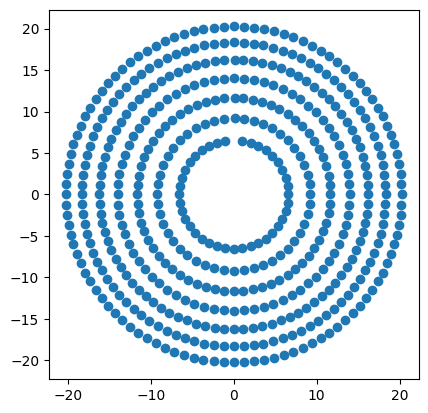

In [6]:
plt.scatter(sensor_pos_interp[0,:].cpu(),sensor_pos_interp[1,:].cpu())
plt.gca().set_aspect('equal')
print(sensor_pos_interp.shape)

In [7]:
## Simulation
def voxelize_spheres(rsphere, Rs, grid_size=128, bounding_box=2e-3):
    """
    Voxelizes spheres into a 3D grid.

    Parameters:
        rsphere (torch.Tensor): Tensor of shape (N, 3) with sphere centers in meters.
        Rs (torch.Tensor): Tensor of shape (N,) with sphere radii in meters.
        grid_size (int): Size of the 3D voxel grid (default: 128).
        bounding_box (float): Size of the bounding box in meters (default: 2e-3).

    Returns:
        torch.Tensor: 3D voxel grid of shape (grid_size, grid_size, grid_size).
    """
    # Compute voxel size
    voxel_size = bounding_box / grid_size

    # Create a 3D grid
    x = torch.linspace(-bounding_box / 2, bounding_box / 2, grid_size)
    y = torch.linspace(-bounding_box / 2, bounding_box / 2, grid_size)
    z = torch.linspace(-bounding_box / 2, bounding_box / 2, grid_size)
    grid_x, grid_y, grid_z = torch.meshgrid(x, y, z, indexing="ij")
    grid_x = grid_x.to(device)
    grid_y = grid_y.to(device)
    grid_z = grid_z.to(device)

    # Initialize a 3D voxel grid
    voxels = torch.zeros((grid_size, grid_size, grid_size), dtype=torch.float32, device=rsphere.device)

    # Compute voxelization
    for i in range(rsphere.shape[0]):
        # Sphere center and radius
        center = rsphere[i]
        radius = Rs[i]

        # Compute squared distances from the grid points to the sphere center
        dist_squared = (
            (grid_x - center[0])**2 +
            (grid_y - center[1])**2 +
            (grid_z - center[2])**2
        )

        # Mark voxels within the sphere's radius
        voxels += (dist_squared <= radius**2).float()

    # Normalize voxels for visualization (clip to 1 as some areas may overlap)
    voxels = torch.clamp(voxels, 0, 1)

    return voxels


# make them a network
def steep_sigmoid(r,alpha=1e6): # approximator for unit step U(r)
    return torch.sigmoid(alpha*r)

# def steep_sigmoid(r):
#     return torch.erf(r*0.1)

def p_init(r, pmag,Rs):
    # the p_init need multiplier so that the signal may match with the actual observation
    return pmag * steep_sigmoid(r) * steep_sigmoid(-r + Rs) * 1e3

def p_init_2d(r, pmag,Rs):
    # the p_init need multiplier so that the signal may match with the actual observation
    return pmag * steep_sigmoid(r + Rs/2) * steep_sigmoid(-r + Rs/2) * 1e3


def get_time_signal(t,r,vs,Rs,pmag):
    first_term      =  (r + vs*t) * p_init( r + vs*t,pmag,Rs) / (2*r) # (r + vs*t) *
    
    second_term     =  p_init(-r + vs*t,pmag,Rs) / (2*r) # (r - vs*t) * 
    third_term      =  p_init( r - vs*t,pmag,Rs) / (2*r) # (r - vs*t) * 

    second_term    *= (r - vs*t)
    third_term     *= (r - vs*t)

    pressure        =  second_term + third_term

    return pressure, second_term, third_term


def get_time_signal_2d(t,r,vs,Rs,pmag):
    pressure        =  0.5*p_init_2d(r - vs*t,pmag,Rs) + 0.5*p_init_2d(r + vs*t,pmag,Rs)
    return pressure

class ForwardModel(nn.Module):
    def __init__(self, sensor_pos, vs, Fs,start_t,end_t,psf,rimage,device):
        super(ForwardModel, self).__init__()
        self.sensor_pos = sensor_pos
        self.vs = vs
        self.Fs = Fs
        self.start_t = start_t
        self.end_t = end_t
        self.psf = psf
        # self.rimage = rimage
        self.device = device

    def forward(self, rsphere, Rs,pmag):
        rsensor = self.sensor_pos.T * 1e-3
        rs      = torch.cdist(rsphere.unsqueeze(0),rsensor.unsqueeze(0)).squeeze(0)
        t       = torch.arange(self.start_t,self.end_t) * (1/self.Fs)
        t       = t.to(self.device)

        rsgrid_mult,tgrid_mult  = torch.meshgrid(rs.flatten(),t,indexing='ij')
        rsgrid_mult             = rsgrid_mult.reshape(rs.shape[0],rs.shape[1],len(t))
        tgrid_mult              = tgrid_mult.reshape(rs.shape[0],rs.shape[1],len(t))

        traces,second_term,third_term  = get_time_signal(tgrid_mult,rsgrid_mult,self.vs,Rs.unsqueeze(-1).unsqueeze(-1),pmag.unsqueeze(-1).unsqueeze(-1))
        traces_bp                      = get_time_signal_2d(tgrid_mult,rsgrid_mult,self.vs,Rs.unsqueeze(-1).unsqueeze(-1),pmag.unsqueeze(-1).unsqueeze(-1))
        # everything ideally propagates as N-shape
        # print(traces.shape)
        if self.psf != None:
            AA = F.conv1d(traces.sum(0).unsqueeze(1),self.psf[:-1].unsqueeze(0).unsqueeze(0).to(self.device),padding='same').squeeze()
            return AA , traces.sum(0),traces_bp.sum(0)
        else:
            return traces.sum(0)

In [8]:
# get simulated rods
rimage = 1.5*1e-3 # in meters
vs     = cPA   # in meters

Simulator    = ForwardModel(
    sensor_pos=sensor_pos_interp,
    vs = vs,
    Fs = Fs,
    start_t = start_time_PA,
    end_t = end_time_PA,
    psf=torch.tensor(psf.real,dtype=torch.float),
    rimage = rimage,
    device=device
)
def get_simulated_rods():

    # compare with actual data
    # location of the sphere
    # rsphere = torch.zeros(390,3)
    # rsphere[:128,0] = torch.linspace(-1.5,1.5,128)
    # rsphere[:128,1] = torch.linspace(-1,1.2,128) + 1.0
    # rsphere[:128,2] = 0.4
    # rsphere[128:256,0] = torch.linspace(-1.5,1.5,128)
    # rsphere[128:256,1] = torch.linspace(-1,1.2,128)
    # rsphere[128:256,2] = -0.5
    # rsphere[256:384,0] = torch.linspace(-1.5,1.5,128)
    # rsphere[256:384,1] = torch.linspace(-1,0.7,128) - 1.0
    # rsphere[256:384,2] = -1.8

    # rsphere[384:,2] = -0.5
    
    # rsphere = rsphere * 1e-3
    # Rs      = torch.ones(rsphere.shape[0]).to(device) * 70e-6

    def rand_f():
        return torch.rand(1) * 2 * rimage - rimage

    nrods = 10
    px_each_rods = 64
    rsphere = torch.zeros(nrods*px_each_rods,3)
    Rs      = (torch.ones(rsphere.shape[0]).to(device)) * 70e-6 # maximum size of spheres
    for i in range(nrods):
        rsphere[(i*px_each_rods):(i+1)*px_each_rods,0] = torch.linspace(rand_f()[0],rand_f()[0],px_each_rods)
        rsphere[(i*px_each_rods):(i+1)*px_each_rods,1] = torch.linspace(rand_f()[0],rand_f()[0],px_each_rods)
        rsphere[(i*px_each_rods):(i+1)*px_each_rods,2] = torch.linspace(rand_f()[0],rand_f()[0],px_each_rods)
        Rs[(i*px_each_rods):(i+1)*px_each_rods] = (torch.randn(1)+0.01) * 70e-6

    # nspheres = torch.randint(1,128,(1,))[0]
    # print(nspheres.shape)
    # rsphere  = torch.randn(nspheres,3) * 2 * rimage - rimage



    # cconvert the rsphere
    rsphere = rsphere.to(device)
    # radius of the sphere
    
    # pressure magnitude
    pmag    = torch.ones(rsphere.shape[0]).to(device)

    # this simulates the forward function
    # albeit all in pytorch and "seems" trainiable
    # the fact that the sigmoid involves a huge parameters to achieve sharpness of N-shape
    # making the network hardly trainable
    syntheticPAx2,syntheticPAx2_fullband,syntheticPAx2_bp = Simulator(rsphere,Rs,pmag)
    
    voxgt       = voxelize_spheres(rsphere,Rs,128,2*rimage)

    del rsphere, Rs, pmag

    return syntheticPAx2,syntheticPAx2_fullband,syntheticPAx2_bp

def get_simulated_random(nspheres,radius_max):

    # nspheres = 8
    rsphere  = torch.rand(nspheres,3) * 2 * rimage - rimage
    # print(rsphere*1e3)
    # Rs = (torch.rand(nspheres)) * radius_max
    Rs = (torch.randn(nspheres) + 3) * 33e-6
    Rs = abs(Rs)

    # cconvert the rsphere
    rsphere = rsphere.to(device)
    Rs = Rs.to(device)
    # radius of the sphere
    
    # pressure magnitude
    pmag    = torch.ones(rsphere.shape[0]).to(device)

    # this simulates the forward function
    # albeit all in pytorch and "seems" trainiable
    # the fact that the sigmoid involves a huge parameters to achieve sharpness of N-shape
    # making the network hardly trainable
    syntheticPAx2,syntheticPAx2_fullband,syntheticPAx2_bp = Simulator(rsphere,Rs,pmag)
    
    voxgt       = voxelize_spheres(rsphere,Rs,128,2*rimage)

    del rsphere, Rs, pmag

    return syntheticPAx2,syntheticPAx2_fullband,syntheticPAx2_bp

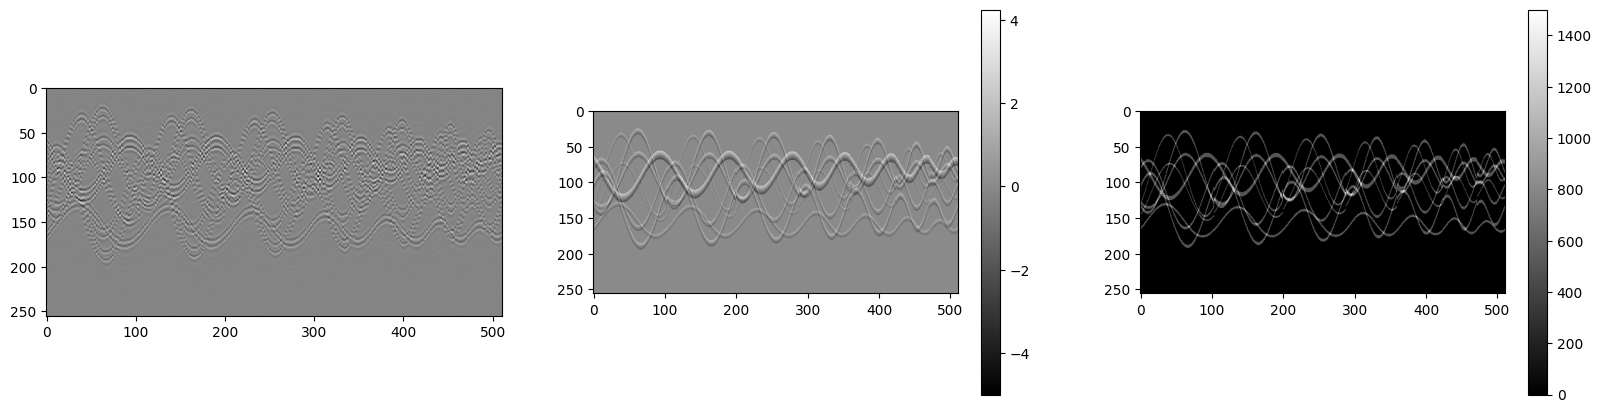

In [9]:
syntheticPAx2,syntheticPAx2_fullband,syntheticPAx2_bp =  get_simulated_random(8,10e-6)
inp = F.interpolate(syntheticPAx2.cpu().T[:,::2].unsqueeze(0).unsqueeze(0),(syntheticPAx2.shape[1],syntheticPAx2.shape[0])).squeeze(0).squeeze(0)

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.imshow(inp,cmap='gray')
plt.subplot(132)
plt.imshow(syntheticPAx2_fullband.cpu().T,cmap='gray')
plt.colorbar()

plt.subplot(133)
plt.imshow(syntheticPAx2_bp.cpu().T,cmap='gray')
plt.colorbar()
plt.show()


In [10]:
# from PIL import Image
# from skimage.morphology import skeletonize
# from scipy.ndimage import distance_transform_edt
# rimage = 1.5*1e-3
# def get_image_coarse():
#     # load image
#     resolution = 50e-6
#     pximg = int(2*rimage // resolution) # to obtain an image of 3mm x 3mm x 3mm, we need 

#     x_max = 1303# voi: 1928
#     y_max = 912# voi: 1928
#     z_max = 2278# voi: 1396

#     slicex = np.random.randint(0,x_max - pximg)
#     slicey = np.random.randint(0,y_max - pximg)
#     slicez = np.random.randint(0,z_max - pximg)

#     train_vox = np.zeros((pximg,pximg,pximg))
#     for ii,iz in enumerate(range(slicez,slicez+pximg)):
#         with Image.open(f'dataset/kaggle_sennethoa/kidney_1_labels/{str(iz).zfill(4)}.tif') as img:
#             tif_array = np.array(img)
#             train_vox[ii,:,:] = tif_array[slicex:(slicex+pximg),slicey:(slicey+pximg)]

#     # resample to 128 x 128 x 128
#     train_vox = F.interpolate(torch.tensor(train_vox).unsqueeze(0).unsqueeze(0), size=(128, 128, 128), mode='trilinear', align_corners=False)
#     train_vox = train_vox.squeeze(0).squeeze(0).cpu().numpy()
#     train_vox = train_vox / 255
#     train_vox[train_vox > 0.01] = 1
#     train_vox[train_vox <= 0.01] = 0

#     return train_vox


# def get_image_fine():
#     # load image
#     resolution = 5.2e-6
#     pximg = int(2*rimage // resolution) # to obtain an image of 3mm x 3mm x 3mm, we need 

#     x_max = 1928# voi: 1928
#     y_max = 1928# voi: 1928
#     z_max = 1396# voi: 1396

#     slicex = np.random.randint(0,x_max - pximg)
#     slicey = np.random.randint(0,y_max - pximg)
#     slicez = np.random.randint(0,z_max - pximg)

#     train_vox = np.zeros((pximg,pximg,pximg))
#     for ii,iz in enumerate(range(slicez,slicez+pximg)):
#         with Image.open(f'dataset/kaggle_sennethoa/kidney_1_voi_labels/{str(iz).zfill(4)}.tif') as img:
#             tif_array = np.array(img)
#             train_vox[ii,:,:] = tif_array[slicex:(slicex+pximg),slicey:(slicey+pximg)]

#     # resample to 128 x 128 x 128
#     train_vox = F.interpolate(torch.tensor(train_vox).unsqueeze(0).unsqueeze(0), size=(128, 128, 128), mode='trilinear', align_corners=False)
#     train_vox = train_vox.squeeze(0).squeeze(0).cpu().numpy()
#     train_vox = train_vox / 255
#     train_vox[train_vox > 0.01] = 1
#     train_vox[train_vox <= 0.01] = 0

#     return train_vox

# def get_kidney(sensor_pos_loc,mode='coarse'):
#     # get synthetic
#     train_vox = np.zeros((imsz,imsz,imsz))
#     while (train_vox.mean() == 0.0): # make at least 25% coverage
#         if mode=='fine':
#             train_vox = get_image_fine()
#         else:
#             train_vox = get_image_coarse()

#     rimage = 1.5e-3 # in meters
#     vs     = 1475   # in meters

#     net    = ForwardModel(
#         sensor_pos=sensor_pos_loc,
#         vs = vs,
#         Fs = Fs,
#         start_t = start_time_PA,
#         end_t = end_time_PA,
#         psf=torch.tensor(psf,dtype=torch.float),# torch.tensor(psf,dtype=torch.float)
#         rimage = rimage,
#         device=device
#     )

#     # get skeleton
#     points,radii,voxskeleton = get_skeleton(train_vox)
#     pmag = torch.ones(points.shape[0],dtype=torch.float)
#     # get simulation
#     syntheticPAx2,syntheticPAx2_fullband = net(torch.tensor(points,dtype=torch.float).to(device),torch.tensor(radii,dtype=torch.float).to(device),pmag.to(device))
#     syntheticPAx2 = syntheticPAx2 / syntheticPAx2.abs().max()
#     syntheticPAx2_fullband = syntheticPAx2_fullband / syntheticPAx2_fullband.abs().max()
#     return syntheticPAx2,syntheticPAx2_fullband, voxskeleton

# def get_skeleton(binary_mask):
#     rimage = 1.5e-3
#     skeleton = skeletonize(binary_mask)
#     points = np.argwhere(skeleton > 0)  # Get coordinates of skeleton points
#     dx = 2 * rimage / imsz # one voxel size
#     points = (points -imsz//2) * dx
#     distances = distance_transform_edt(binary_mask)
#     radii = distances[skeleton > 0] * dx  # Get radii for each skeleton point
#     voxskeleton = voxelize_spheres(torch.tensor(points).to(device),torch.tensor(radii).to(device),imsz,2*rimage)
#     return points,radii,voxskeleton

# Paper 1

`Deep Neural Network-based Sinogram Super-Resolution and Bandwidth Enhancement for Limited-data Photoacosutic Tomography`

by Navchetan Awasthi et al, IEEE T-UFFC (Prof. Manojit Pramanik)

Related papers:
- `Deep-Neural-Network-Based Sinogram Synthesis for Sparse-View CT Image Reconstruction` by H. Lee on IEEE T. Radiation & Plasma 3 (2), 2019. 
    - The exact same idea, but different implementation


Comments:
- none of these papers mentioned why using patch

In [11]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate    

class Sine(nn.Module):
    def forward(self, x):
        return torch.sin(x)#
    
def sine_init(m, omega=30):
    if isinstance(m, nn.Conv2d):
        with torch.no_grad():
            m.weight.uniform_(-1/omega, 1/omega)

class SoftShrinkageActivation(nn.Module):
    def __init__(self, lambd):
        super(SoftShrinkageActivation, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return torch.sign(x) * torch.maximum(torch.abs(x) - self.lambd, torch.zeros_like(x))

from torch.nn.functional import interpolate
def split_into_patches(image: torch.Tensor, patch_size: tuple) -> torch.Tensor:
    """
    Splits an image into non-overlapping patches and treats each patch as a batch.
    
    Args:
        image (torch.Tensor): Input tensor of shape (Batch, Channel, Height, Width).
        patch_size (tuple): Tuple indicating the size of each patch (Height, Width).
        
    Returns:
        torch.Tensor: Patches of shape (NumPatches, Channels, PatchHeight, PatchWidth).
    """
    # Calculate padding
    _, _, height, width = image.shape
    pad_h = (patch_size[0] - height % patch_size[0]) % patch_size[0]
    pad_w = (patch_size[1] - width % patch_size[1]) % patch_size[1]

    # Pad the image
    padded_image = F.pad(image, (0, pad_w, 0, pad_h))  # Padding: (Left, Right, Top, Bottom)

    # Use nn.Unfold to extract patches
    unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size)
    patches = unfold(padded_image)  # Shape: (Batch, PatchSize*PatchSize*Channels, NumPatches)

    # Reshape to make each patch a batch
    patches = patches.permute(0, 2, 1)  # Move patches to the second dimension
    patches = patches.view(-1, image.shape[1], patch_size[0], patch_size[1])  # (NumPatches, Channels, PatchHeight, PatchWidth)

    return patches

def reconstruct_from_patches(patches: torch.Tensor, original_size: tuple, patch_size: tuple) -> torch.Tensor:
    """
    Reconstructs the original image from non-overlapping patches.
    
    Args:
        patches (torch.Tensor): Patches of shape (NumPatches, Channels, PatchHeight, PatchWidth).
        original_size (tuple): Original size of the image (Height, Width).
        patch_size (tuple): Tuple indicating the size of each patch (PatchHeight, PatchWidth).
        
    Returns:
        torch.Tensor: Reconstructed image of shape (Batch, Channels, Height, Width).
    """
    # Get the number of patches per dimension
    batch_size = 1  # Assuming patches came from one image
    channels = patches.shape[1]
    padded_height = (original_size[0] + patch_size[0] - 1) // patch_size[0] * patch_size[0]
    padded_width = (original_size[1] + patch_size[1] - 1) // patch_size[1] * patch_size[1]
    
    # Reshape patches back to the unfolded shape
    num_patches_h = padded_height // patch_size[0]
    num_patches_w = padded_width // patch_size[1]
    patches = patches.reshape(batch_size, num_patches_h * num_patches_w, -1).permute(0, 2, 1)

    # Reconstruct the padded image using Fold
    fold = torch.nn.Fold(output_size=(padded_height, padded_width), kernel_size=patch_size, stride=patch_size)
    reconstructed_image = fold(patches)

    # Remove padding to restore original dimensions
    reconstructed_image = reconstructed_image[:, :, :original_size[0], :original_size[1]]
    return reconstructed_image
    

In [12]:
class DNNSinogramSR(nn.Module):

    def __init__(self, activ_func1, activ_func2,in_channels=1,out_channels=1, f = 32):

        super(DNNSinogramSR, self).__init__()
        # print('Old')
        # print('\n')
        self.f = f
        activ_func = activ_func1
        ksize = 3
        padsize = 1
        self.conv1_block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=self.f,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f, out_channels=self.f,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )
        self.max1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        

        # Conv block 2 - Down 2
        self.conv2_block = nn.Sequential(
            nn.Conv2d(in_channels=f, out_channels=self.f*2,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*2, out_channels=self.f*2,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )
        self.max2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        

        # Conv block 3 - Down 3
        self.conv3_block = nn.Sequential(
            nn.Conv2d(in_channels=self.f*2, out_channels=self.f*4,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*4, out_channels=self.f*4,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )
        self.max3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        

        # Conv block 4 - Down 4
        self.conv4_block = nn.Sequential(
            nn.Conv2d(in_channels=self.f*4, out_channels=self.f*8,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*8, out_channels=self.f*8,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )
        self.max4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        

        # Conv block 5 - Down 5
        self.conv5_block = nn.Sequential(
            nn.Conv2d(in_channels=self.f*8, out_channels=self.f*16,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*16, out_channels=self.f*16,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )
        
        

        # Up 1
        self.up_1 = nn.ConvTranspose2d(in_channels=self.f*16, out_channels=self.f*8, kernel_size=2, stride=2)

        # Up Conv block 1
        self.conv_up_1 = nn.Sequential(
            nn.Conv2d(in_channels=self.f*16, out_channels=self.f*8,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*8, out_channels=self.f*8,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )

        # Up 2
        self.up_2 = nn.ConvTranspose2d(in_channels=self.f*8, out_channels=self.f*4, kernel_size=2, stride=2)

        # Up Conv block 2
        self.conv_up_2 = nn.Sequential(
            nn.Conv2d(in_channels=self.f*8, out_channels=self.f*4,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*4, out_channels=self.f*4,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )

        # Up 3
        self.up_3 = nn.ConvTranspose2d(in_channels=self.f*4, out_channels=self.f*2, kernel_size=2, stride=2)

        # Up Conv block 3
        self.conv_up_3 = nn.Sequential(
            nn.Conv2d(in_channels=self.f*4, out_channels=self.f*2,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*2, out_channels=self.f*2,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )

        # Up 4
        self.up_4 = nn.ConvTranspose2d(in_channels=self.f*2, out_channels=self.f, kernel_size=2, stride=2)

        # Up Conv block 4
        self.conv_up_4 = nn.Sequential(
            nn.Conv2d(in_channels=self.f*2, out_channels=self.f,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f, out_channels=self.f,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )

        # Final output
        # self.conv_final = nn.Conv2d(in_channels=32, out_channels=2,
        #                             kernel_size=1, padding=0, stride=1)

        self.conv_final = nn.Sequential(
            nn.Conv2d(in_channels=self.f, out_channels=out_channels, # use channels 2 for positive negative output
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func2,
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func2,
        )

    def forward(self, x):
        # print('input', x.shape)

        # Down 1
        x = self.conv1_block(x)
        # print('after conv1', x.shape)
        conv1_out = x  # Save out1
        conv1_dim = x.shape[2]
        x = self.max1(x)
        # print('before conv2', x.shape)

        # Down 2
        x = self.conv2_block(x)
        # print('after conv2', x.shape)
        conv2_out = x
        conv2_dim = x.shape[2]
        x = self.max2(x)
        # print('before conv3', x.shape)

        # Down 3
        x = self.conv3_block(x)
        # print('after conv3', x.shape)
        conv3_out = x
        conv3_dim = x.shape[2]
        x = self.max3(x)
        # print('before conv4', x.shape)

        # Down 4
        x = self.conv4_block(x)
        # print('after conv5', x.shape)
        conv4_out = x
        conv4_dim = x.shape[2]
        x = self.max4(x)
        # print('after conv4', x.shape)

        # Midpoint
        x = self.conv5_block(x)
        # print('mid', x.shape)

        # Up 1
        x = self.up_1(x)
        # print('up_1', x.shape)
        lower = int((conv4_dim - x.shape[2]) / 2)
        upper = int(conv4_dim - lower)
        conv4_out_modified = conv4_out[:, :, lower:upper, lower:upper]
        x = torch.cat([x, conv4_out_modified], dim=1)
        # print('after cat_1', x.shape)
        x = self.conv_up_1(x)
        # print('after conv_1', x.shape)

        # Up 2
        x = self.up_2(x)
        # print('up_2', x.shape)
        lower = int((conv3_dim - x.shape[2]) / 2)
        upper = int(conv3_dim - lower)
        conv3_out_modified = conv3_out[:, :, lower:upper, lower:upper]
        x = torch.cat([x, conv3_out_modified], dim=1)
        # print('after cat_2', x.shape)
        x = self.conv_up_2(x)
        # print('after conv_2', x.shape)

        # Up 3
        x = self.up_3(x)
        # print('up_3', x.shape)
        lower = int((conv2_dim - x.shape[2]) / 2)
        upper = int(conv2_dim - lower)
        conv2_out_modified = conv2_out[:, :, lower:upper, lower:upper]
        x = torch.cat([x, conv2_out_modified], dim=1)
        # print('after cat_3', x.shape)
        x = self.conv_up_3(x)
        # print('after conv_3', x.shape)

        # Up 4
        x = self.up_4(x)
        # print('up_4', x.shape)
        lower = int((conv1_dim - x.shape[2]) / 2)
        upper = int(conv1_dim - lower)
        conv1_out_modified = conv1_out[:, :, lower:upper, lower:upper]
        x = torch.cat([x, conv1_out_modified], dim=1)
        # print('after cat_4', x.shape)
        x = self.conv_up_4(x)
        # print('after conv_4', x.shape)

        # Final output
        x = self.conv_final(x)

        # if positive 2 channels
        # if (x.shape[1] == 2):
            # x = -x[:,0,:,:] + x[:,1,:,:]
            # x = x.unsqueeze(1)

        return x

In [13]:
class DNNSinogramSRPruned(nn.Module):

    def __init__(self, activ_func1, activ_func2, f = 32,ksize=3,padsize=1):

        super(DNNSinogramSRPruned, self).__init__()
        # print('Old')
        # print('\n')
        self.f = f
        activ_func = activ_func1
        # ksize = 5
        # padsize = 2
        self.conv1_block = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=self.f,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f, out_channels=self.f,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )
        self.max1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        

        # Conv block 2 - Down 2
        self.conv2_block = nn.Sequential(
            nn.Conv2d(in_channels=f, out_channels=self.f*2,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*2, out_channels=self.f*2,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )
        self.max2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        

        # Conv block 3 - Down 3
        self.conv3_block = nn.Sequential(
            nn.Conv2d(in_channels=self.f*2, out_channels=self.f*4,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*4, out_channels=self.f*4,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )
        self.max3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        

        # Conv block 4 - Down 4
        self.conv4_block = nn.Sequential(
            nn.Conv2d(in_channels=self.f*4, out_channels=self.f*8,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*8, out_channels=self.f*8,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )
        self.max4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        

        # Conv block 5 - Down 5
        self.conv5_block = nn.Sequential(
            nn.Conv2d(in_channels=self.f*8, out_channels=self.f*16,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*16, out_channels=self.f*16,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )
        
        

        # Up 1
        self.up_1 = nn.ConvTranspose2d(in_channels=self.f*16, out_channels=self.f*8, kernel_size=2, stride=2)

        # Up Conv block 1
        self.conv_up_1 = nn.Sequential(
            nn.Conv2d(in_channels=self.f*16, out_channels=self.f*8,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*8, out_channels=self.f*8,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )

        # Up 2
        self.up_2 = nn.ConvTranspose2d(in_channels=self.f*8, out_channels=self.f*4, kernel_size=2, stride=2)

        # Up Conv block 2
        self.conv_up_2 = nn.Sequential(
            nn.Conv2d(in_channels=self.f*8, out_channels=self.f*4,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*4, out_channels=self.f*4,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )

        # Up 3
        self.up_3 = nn.ConvTranspose2d(in_channels=self.f*4, out_channels=self.f*2, kernel_size=2, stride=2)

        # Up Conv block 3
        self.conv_up_3 = nn.Sequential(
            nn.Conv2d(in_channels=self.f*4, out_channels=self.f*2,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*2, out_channels=self.f*2,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )

        # Up 4
        self.up_4 = nn.ConvTranspose2d(in_channels=self.f*2, out_channels=self.f, kernel_size=2, stride=2)

        # Up Conv block 4
        self.conv_up_4 = nn.Sequential(
            nn.Conv2d(in_channels=self.f*2, out_channels=self.f,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f, out_channels=self.f,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )

        # Final output
        # self.conv_final = nn.Conv2d(in_channels=32, out_channels=2,
        #                             kernel_size=1, padding=0, stride=1)

        self.conv_final = nn.Sequential(
            nn.Conv2d(in_channels=self.f, out_channels=1, # use channels 2 for positive negative output
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func2,
            nn.Conv2d(in_channels=1, out_channels=1,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func2,
        )

    def forward(self, x):
        # print('input', x.shape)

        # Down 1
        x = self.conv1_block(x)
        # print('after conv1', x.shape)
        conv1_out = x  # Save out1
        conv1_dim = x.shape[2]
        x = self.max1(x)
        # print('before conv2', x.shape)

        # Down 2
        x = self.conv2_block(x)
        # print('after conv2', x.shape)
        conv2_out = x
        conv2_dim = x.shape[2]
        x = self.max2(x)
        # print('before conv3', x.shape)

        # Down 3
        x = self.conv3_block(x)
        # print('after conv3', x.shape)
        conv3_out = x
        conv3_dim = x.shape[2]
        x = self.max3(x)
        # print('before conv4', x.shape)

        # midpoint
        x = self.conv4_block(x)

        # Up 1

        # Up 2
        x = self.up_2(x)
        # print('up_2', x.shape)
        lower = int((conv3_dim - x.shape[2]) / 2)
        upper = int(conv3_dim - lower)
        conv3_out_modified = conv3_out[:, :, lower:upper, lower:upper]
        x = torch.cat([x, conv3_out_modified], dim=1)
        # print('after cat_2', x.shape)
        x = self.conv_up_2(x)
        # print('after conv_2', x.shape)

        # Up 3
        x = self.up_3(x)
        # print('up_3', x.shape)
        lower = int((conv2_dim - x.shape[2]) / 2)
        upper = int(conv2_dim - lower)
        conv2_out_modified = conv2_out[:, :, lower:upper, lower:upper]
        x = torch.cat([x, conv2_out_modified], dim=1)
        # print('after cat_3', x.shape)
        x = self.conv_up_3(x)
        # print('after conv_3', x.shape)

        # Up 4
        x = self.up_4(x)
        # print('up_4', x.shape)
        lower = int((conv1_dim - x.shape[2]) / 2)
        upper = int(conv1_dim - lower)
        conv1_out_modified = conv1_out[:, :, lower:upper, lower:upper]
        x = torch.cat([x, conv1_out_modified], dim=1)
        # print('after cat_4', x.shape)
        x = self.conv_up_4(x)
        # print('after conv_4', x.shape)

        # Final output
        x = self.conv_final(x)

        # if positive 2 channels
        # if (x.shape[1] == 2):
            # x = -x[:,0,:,:] + x[:,1,:,:]
            # x = x.unsqueeze(1)

        return x

In [14]:
# def init_weights_xavier(m):
#     if isinstance(m, nn.Conv2d):
#         torch.nn.init.xavier_normal_(m.weight)

# def init_weights_kaiming(m):
#     if isinstance(m, nn.Conv2d):
#         torch.nn.init.kaiming_normal_(m.weight)

net         = DNNSinogramSR(
    Sine(),
    Sine(),
    ).to(device)

# net.apply(init_weights_xavier)

net2         = DNNSinogramSR(
    nn.ReLU(),
    nn.ELU(),
    ).to(device) # OG model
# net2.apply(init_weights_kaiming)

# the input is strided patch of 64 x 64 in size
# and 16 by 16 in strides
optimizer    = torch.optim.Adam( net.parameters(),1e-5)
optimizer2   = torch.optim.Adam(net2.parameters(),1e-5)

# scheduler reduce on plateau
# scheduler    = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer ,factor=0.9,patience=1000,min_lr=1e-5)
# scheduler2   = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2,factor=0.9,patience=1000,min_lr=1e-5)

# PATH        = os.path.expanduser(f"~/Documents/training_checkpoint/UNETPatch/v2/relu_sine/compare/training_2_1e-5/model{20000}.pth")
# net.load_state_dict(torch.load(PATH, weights_only=True))

# PATH        = os.path.expanduser(f"~/Documents/training_checkpoint/UNETPatch/v2/relu_tanh/compare/training_2_1e-5/model{20000}.pth")
# net2.load_state_dict(torch.load(PATH, weights_only=True))

summary(net.cpu(),input_size=(1,512,256),device='cpu')
patch_size = (64,64)
net = net.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 256]             320
              Sine-2         [-1, 32, 512, 256]               0
              Sine-3         [-1, 32, 512, 256]               0
              Sine-4         [-1, 32, 512, 256]               0
              Sine-5         [-1, 32, 512, 256]               0
              Sine-6         [-1, 32, 512, 256]               0
              Sine-7         [-1, 32, 512, 256]               0
              Sine-8         [-1, 32, 512, 256]               0
              Sine-9         [-1, 32, 512, 256]               0
             Sine-10         [-1, 32, 512, 256]               0
           Conv2d-11         [-1, 32, 512, 256]           9,248
             Sine-12         [-1, 32, 512, 256]               0
             Sine-13         [-1, 32, 512, 256]               0
             Sine-14         [-1, 32, 5

**Notes**

1. Try training without patching --> eliminates the boundary error and see if it works
2. The aliasing sometimes corrected

In [ ]:
def fk_filter(test):
    ntime = test.shape[0]
    nsensor = test.shape[1]
    nseg = 4
    #
    test = test.view(ntime,nseg,-1).permute(1,2,0)
    testft = torch.fft.fftshift(torch.fft.fft2(test),dim=(1,2))
    testft[:,32,:] = 0

    rec = torch.fft.ifft2(torch.fft.ifftshift(testft,dim=(1,2))).permute(2,0,1).view(ntime,nsensor).real

    return rec

we train each number of spheres to be trained to the UNET

4, 8, 16,32 each 10 trials

learning rate of 1e-4

In [ ]:
for nspheremax in range(4,5):
    # nspheremax = 2**nspheremax_pow
    net         = DNNSinogramSR(
        Sine(),
        Sine(),
        ).to(device)

    # net.apply(init_weights_xavier)

    # net2         = DNNSinogramSR(
    #     nn.ReLU(),
    #     nn.ELU(),
    #     ).to(device) # OG model
    # net2.apply(init_weights_kaiming)

    # the input is strided patch of 64 x 64 in size
    # and 16 by 16 in strides
    optimizer    = torch.optim.Adam( net.parameters(),1e-4)
    # optimizer2   = torch.optim.Adam(net2.parameters(),1e-4)

    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.9,min_lr=5e-5)

    # non-patched
    STARTITER = 0
    MAXITER = STARTITER + 40000 + 1
    tq = tqdm(range(STARTITER,MAXITER))
    lossval   = torch.zeros(MAXITER)
    lossval1  = torch.zeros(MAXITER)
    lossval2  = torch.zeros(MAXITER)
    lossval22 = torch.zeros(MAXITER)
    freqval   = torch.zeros(MAXITER)


    # validation 1
    test,test_fullband,_ = get_simulated_random(nspheremax,150e-6)
    test_fullband = test_fullband / test_fullband.abs().max()
    test_fullband = test_fullband.to(device)
    test = test / test.abs().max()
    test = test.to(device)  
    test_interped = interpolate(test[::2,:].unsqueeze(0).unsqueeze(0),(test[::2,:].shape[0]*2,test.shape[1]),mode='bilinear')
  
    for i in (tq):
        net.train()
        # net2.train()
        optimizer.zero_grad()
        # optimizer2.zero_grad()
        syntheticPAx2,syntheticPAx2_fullband,syntheticPAx2_bp =  get_simulated_random(nspheremax,150e-6)
        # syntheticPAx2,syntheticPAx2_fullband,voxgt,_,_ =  get_simulated_random(nspheremax)
        syntheticPAx2 = syntheticPAx2 / syntheticPAx2.abs().max()
        syntheticPAx2_fullband = syntheticPAx2_fullband / syntheticPAx2_fullband.abs().max() # target output
        # syntheticPAx2_bp = syntheticPAx2_bp / syntheticPAx2_bp.abs().max()# target output v2

        # input
        syntheticPAx1 = syntheticPAx2[::2,:] # I changed this previously
        # syntheticPAx1 = fk_filter(syntheticPAx1.T).T
        # break
        # fk filter

        # do interpolation
        syntheticPAx1 = interpolate(syntheticPAx1.unsqueeze(0).unsqueeze(0),(syntheticPAx1.shape[0]*2,syntheticPAx1.shape[1]),mode='bilinear')

        out  = net(syntheticPAx1.to(device))
        # out2 = net2(syntheticPAx1.to(device))
        mseloss = nn.MSELoss()(out.squeeze(0).squeeze(0)[:-1,:] ,syntheticPAx2_fullband) 
        regl2 = torch.norm(out.squeeze(0).squeeze(0)[:-1,:],2)*1e-5
        # print(mseloss,regl2)
        # break
        loss  = mseloss+regl2#+ lossdc * 1e-3
        # loss2 = nn.MSELoss()(out2.squeeze(0).squeeze(0)[:-1,:],syntheticPAx2_fullband) #+ lossdc2 * 1e-3


        loss.backward()
        # loss2.backward()
        # for name, param in net.named_parameters():
        #     print(f'Gradient of {name}: {param.grad}')
        optimizer.step()
        # optimizer2.step()
        
        with torch.no_grad():
            net.eval()
            out  = net(test_interped.to(device)) 
            valloss  = nn.MSELoss()(out.squeeze(0).squeeze(0)[:-1,:],test_fullband)
            lossval[i] = valloss.item()
            tq.set_postfix(train_error=f"{loss.item():.5f}",val_error=f"{valloss.item():.5f}")
            # scheduler.step(valloss)


        # if (i % 5000) == 0:
        #     torch.save( net.state_dict(), os.path.expanduser(f"~/Documents/training_checkpoint/UNETPatch/v2/sine_sine/random8_noFK/model{i}.pth"))
        #     torch.save(net2.state_dict(), os.path.expanduser(f"~/Documents/training_checkpoint/UNETPatch/v2/OG/random8_noFK/model{i}.pth"))
    # torch.save(net.state_dict(), os.path.expanduser(f"~/Documents/training_checkpoint/UNETPatch/v2/model{MAXITER-1}.pth"))
    torch.save( net.state_dict(), os.path.expanduser(f"~/Documents/training_checkpoint/UNETPatch/v2/sine_sine/stability_300umMax/modelNoFK_{'test'}_{nspheremax}.pth"))
    # torch.save(net2.state_dict(), os.path.expanduser(f"~/Documents/training_checkpoint/UNETPatch/v2/OG/stability_300umMax_v2/modelNoFK_{total_iter}_{nspheremax}.pth"))

In [ ]:
plt.semilogy(lossval)

In [ ]:
plt.semilogy(lossval)

In [ ]:
# # patched
# MAXITER = 20000 + 1
# tq = tqdm(range(MAXITER))
# lossval  = torch.zeros(MAXITER)
# lossval1  = torch.zeros(MAXITER)
# lossval2  = torch.zeros(MAXITER)
# lossval22 = torch.zeros(MAXITER)
# freqval   = torch.zeros(MAXITER)
# freqval2  = torch.zeros(MAXITER)


# # validation 1
# test = datPA
# test = test / test.abs().max()
# test = test.to(device)
# test_interped = interpolate(test[:,::2].unsqueeze(0).unsqueeze(0),(test.shape[0]*2,test.shape[1]),mode='bilinear').squeeze(0).squeeze(0)
# test_patch_val = split_into_patches(test_interped.T.unsqueeze(0).unsqueeze(0),patch_size)
# maxval = torch.amax(test_patch_val.abs(),dim=(2,3)).unsqueeze(-1).unsqueeze(-1)

# # validation 2
# syntheticPAx2,syntheticPAx2_fullband,_,_,_ =  get_simulated_rods()
# syntheticPAx2 = syntheticPAx2 / syntheticPAx2.abs().max()
# syntheticPAx1 = syntheticPAx2[::2,::2]
# syntheticPAx1 = interpolate(syntheticPAx1.unsqueeze(0).unsqueeze(0),(syntheticPAx1.shape[0]*2,syntheticPAx1.shape[1]*2),mode='bilinear').squeeze(0).squeeze(0)
# test_patch_val_2 = split_into_patches(syntheticPAx1.T.unsqueeze(0).unsqueeze(0),patch_size)
# gt_patch_val_2   = split_into_patches(syntheticPAx2.T.unsqueeze(0).unsqueeze(0),patch_size)
# gt_fullband_patch_val_2   = split_into_patches(syntheticPAx2_fullband.T.unsqueeze(0).unsqueeze(0),patch_size)

# padsize = 8

# test_patch_val            = F.pad(test_patch_val,(padsize,padsize,padsize,padsize))
# test_patch_val_2          = F.pad(test_patch_val_2,(padsize,padsize,padsize,padsize))
# gt_patch_val_2            = F.pad(gt_patch_val_2,(padsize,padsize,padsize,padsize))
# gt_fullband_patch_val_2   = F.pad(gt_fullband_patch_val_2,(padsize,padsize,padsize,padsize))

# for i in (tq):
#     net.train()
#     net2.train()
#     optimizer.zero_grad()
#     optimizer2.zero_grad()
#     syntheticPAx2,syntheticPAx2_fullband,voxgt,_,_ =  get_simulated_random()
#     syntheticPAx2                                  = syntheticPAx2 / syntheticPAx2.abs().max()
#     syntheticPAx2_fullband                         = syntheticPAx2_fullband / syntheticPAx2_fullband.abs().max() # target output

#     # input
#     syntheticPAx1 = syntheticPAx2[::2,::2]

#     # do interpolation
#     syntheticPAx1 = interpolate(syntheticPAx1.unsqueeze(0).unsqueeze(0),(syntheticPAx1.shape[0]*2,syntheticPAx1.shape[1]*2),mode='bilinear').squeeze(0).squeeze(0)
    

#     # ========================================================================================== # train by pathcches
#     syntheticPAx1 = syntheticPAx1[:-1,:]
#     syntheticPAx1_patch          = split_into_patches(syntheticPAx1.T.unsqueeze(0).unsqueeze(0),patch_size)
#     # syntheticPAx2_patch          = split_into_patches(syntheticPAx2.T.unsqueeze(0).unsqueeze(0),patch_size)
#     syntheticPAx2_fullband_patch = split_into_patches(syntheticPAx2_fullband.T.unsqueeze(0).unsqueeze(0),patch_size)

#     # pad the patch
#     syntheticPAx1_patch = F.pad(syntheticPAx1_patch,(padsize,padsize,padsize,padsize))
#     # syntheticPAx2_patch = F.pad(syntheticPAx2_patch,(padsize,padsize,padsize,padsize))
#     syntheticPAx2_fullband_patch = F.pad(syntheticPAx2_fullband_patch,(padsize,padsize,padsize,padsize))


#     # show all patches
#     out  =  net(syntheticPAx1_patch.to(torch.float)) # output of network is supposed to be the N-shape
#     out2 = net2(syntheticPAx1_patch.to(torch.float)) # output of network is supposed to be the N-shape


#     # print(pimg.shape,syntheticPAx2_fullband.shape)
#     loss  = nn.MSELoss()(out ,syntheticPAx2_fullband_patch)
#     loss2 = nn.MSELoss()(out2,syntheticPAx2_fullband_patch)

#     loss.backward()
#     loss2.backward()


#     optimizer.step()
#     optimizer2.step()

#     with torch.no_grad():
#         # load test data
#         net.eval()
#         net2.eval()
#         # ============================================== synthetic validation
#         out = net(test_patch_val_2.to(device))
#         lossval2[i] = nn.MSELoss()(out,gt_fullband_patch_val_2)
#         out21  =  reconstruct_from_patches(out[:,:,padsize:-padsize,padsize:-padsize],(test.shape[1],test.shape[0]*2-1),patch_size).squeeze(0).squeeze(0).T.detach()

#         out = net2(test_patch_val_2.to(device))
#         lossval22[i] = nn.MSELoss()(out,gt_fullband_patch_val_2)
#         out22  =  reconstruct_from_patches(out[:,:,padsize:-padsize,padsize:-padsize],(test.shape[1],test.shape[0]*2-1),patch_size).squeeze(0).squeeze(0).T.detach()
        
#         gt22   =  reconstruct_from_patches(gt_fullband_patch_val_2[:,:,padsize:-padsize,padsize:-padsize],(test.shape[1],test.shape[0]*2-1),patch_size).squeeze(0).squeeze(0).T.detach()
#         inp22  =  reconstruct_from_patches(test_patch_val_2[:,:,padsize:-padsize,padsize:-padsize],(test.shape[1],test.shape[0]*2-1),patch_size).squeeze(0).squeeze(0).T.detach()

#         refloss2 = nn.MSELoss()(test_patch_val_2,gt_fullband_patch_val_2)

#         # ============================================== patch learning
#         out = net((test_patch_val / maxval).to(device))
#         out = out * maxval
#         out = reconstruct_from_patches(out[:,:,padsize:-padsize,padsize:-padsize],(test.shape[1],test.shape[0]*2-1),patch_size).squeeze(0).squeeze(0).T.detach()

#         out2 = net2((test_patch_val / maxval).to(device))
#         out2 = out2 * maxval
#         out2 = reconstruct_from_patches(out2[:,:,padsize:-padsize,padsize:-padsize],(test.shape[1],test.shape[0]*2-1),patch_size).squeeze(0).squeeze(0).T.detach()
        
        
#         # compare frequency distribution
#         freq_monitoring = nn.MSELoss()(
#             torch.fft.fft(out.T[:, ::2],dim=0).abs().mean(1).cpu()[1:],
#             torch.fft.fft(out.T[:,1::2],dim=0).abs().mean(1).cpu()[1:])

#         refloss     = nn.MSELoss()(test_interped[::2,:].to(device),test)
#         lossval[i]  = nn.MSELoss()( out[::2,:],test).item()
#         lossval1[i] = nn.MSELoss()(out2[::2,:],test).item()

#         freqval[i]  = torch.argmax(abs(torch.fft.fft(out.detach().cpu().T[:,1::2],axis=0)).mean(1)) * Fs * 1e-6 / 256
#         freqval2[i] = torch.argmax(abs(torch.fft.fft(out2.detach().cpu().T[:,1::2],axis=0)).mean(1)) * Fs * 1e-6 / 256
#         # scheduler.step(lossval2[i])
#         # scheduler2.step(lossval22[i])


#         if (i%500)==0:
#             plt.figure(figsize=(20,5))
#             plt.subplot(141)
#             plt.imshow(out21.cpu().T,cmap='gray')
#             plt.subplot(142)
#             plt.imshow(out22.cpu().T,cmap='gray')
#             plt.subplot(143)
#             plt.imshow(gt22.cpu().T,cmap='gray')
#             plt.subplot(144)
#             plt.imshow(inp22.cpu().T,cmap='gray')
#             plt.show()

#             plt.figure(figsize=(20,3))
#             plt.subplot(121)
#             plt.imshow(out.cpu().T,cmap='gray')
#             plt.subplot(122)
#             plt.imshow(out2.cpu().T,cmap='gray')
#             plt.show()


#             plt.figure(figsize=(20,3))
#             plt.subplot(131)
#             # plt.imshow(out[1::2,:].T.detach().cpu())
#             plt.plot(out[:3,:].T.detach().cpu())
#             plt.subplot(132)
#             plt.semilogy(lossval[:i],c='k')
#             plt.semilogy(lossval1[:i],c='k',linestyle=':')
#             plt.semilogy(lossval2[:i],c='r')
#             plt.semilogy(lossval22[:i],c='r',linestyle=':')
#             plt.axhline(refloss.item(),color='k',linestyle='--')
#             plt.axhline(refloss2.item(),color='r',linestyle='--')
#             plt.title(f"{lossval[i].item():.6f}")
#             plt.subplot(133)
#             plt.plot(freqval[:i])
#             plt.plot(freqval2[:i])
#             plt.show()

#     # tq.set_postfix(trainloss=f'{loss:.6f}',lr=f'{scheduler.get_last_lr()}',lr2=f'{scheduler2.get_last_lr()}')
    

#     if (i % 500) == 0:
#         torch.save( net.state_dict(), os.path.expanduser(f"~/Documents/training_checkpoint/UNETPatch/v2/sine_sine/compare/model{i}.pth"))
#         torch.save(net2.state_dict(), os.path.expanduser(f"~/Documents/training_checkpoint/UNETPatch/v2/OG/compare/model{i}.pth"))
# # torch.save(net.state_dict(), os.path.expanduser(f"~/Documents/training_checkpoint/UNETPatch/v2/model{MAXITER-1}.pth"))

In [ ]:
np.save(os.path.expanduser("~/Documents/psf_recorded.npy"),psf)

# Evaluation

## Distribution of Noise at Each Output

In [ ]:
net         = DNNSinogramSR(
    Sine(),
    Sine()
).to(device) # OG model

PATH        = os.path.expanduser(f"~/Documents/training_checkpoint/UNETPatch/v2/identity_sine/stability/modelNoFK_0_4.pth")

net.load_state_dict(torch.load(PATH, weights_only=True))
net = net.to(device)
net.eval()

# Prof Shiina's implementation

In [15]:
class CustomCNN(nn.Module):

    def __init__(self,ich,och,ksz,padsz,activ_func):
        super(CustomCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=ich,out_channels=och,kernel_size=ksz,padding=padsz),
            activ_func
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=och,out_channels=och,kernel_size=ksz,padding=padsz),
            activ_func,
            nn.Conv2d(in_channels=och,out_channels=och,kernel_size=ksz,padding=padsz),
            activ_func,
            nn.Conv2d(in_channels=och,out_channels=och,kernel_size=ksz,padding=padsz),
            activ_func,
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=och,out_channels=och,kernel_size=ksz,padding=padsz),
            activ_func,
            nn.Conv2d(in_channels=och,out_channels=och,kernel_size=ksz,padding=padsz),
            activ_func,
            nn.Conv2d(in_channels=och,out_channels=och,kernel_size=ksz,padding=padsz),
            activ_func,
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=och,out_channels=och,kernel_size=ksz,padding=padsz),
            activ_func,
            nn.Conv2d(in_channels=och,out_channels=och,kernel_size=ksz,padding=padsz),
            activ_func,
            nn.Conv2d(in_channels=och,out_channels=och,kernel_size=ksz,padding=padsz),
            activ_func,
        )
        self.layer5 = nn.Conv2d(in_channels=och,out_channels=och,kernel_size=ksz,padding=padsz)
        self.layer6 = nn.Conv2d(in_channels=och,out_channels=ich,kernel_size=ksz,padding=padsz)
    
    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x1 + x2)
        x4 = self.layer3(x2 + x3)
        x5 = self.layer5(x3 + x4)
        x6 = self.layer6(x + x5)

        return x6

In [ ]:
for nspheremax in range(4,5):
    # nspheremax = 2**nspheremax_pow
    # net         = DNNSinogramSR(
    #     Sine(),
    #     Sine(),
    #     ).to(device)

    # net.apply(init_weights_xavier)

    # net2         = DNNSinogramSR(
    #     nn.ReLU(),
    #     nn.ELU(),
    #     ).to(device) # OG model
    # net2.apply(init_weights_kaiming)

    net = CustomCNN(1,64,(3,3),1,Sine()).to(device)

    # the input is strided patch of 64 x 64 in size
    # and 16 by 16 in strides
    optimizer = torch.optim.Rprop(net.parameters(),1e-5)
    # optimizer    = torch.optim.Adam( net.parameters(),1e-4)
    # optimizer2   = torch.optim.Adam(net2.parameters(),1e-4)

    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.9,min_lr=5e-5)

    # non-patched
    STARTITER = 0
    MAXITER = STARTITER + 40000 + 1
    tq = tqdm(range(STARTITER,MAXITER))
    lossval   = torch.zeros(MAXITER)
    lossval1  = torch.zeros(MAXITER)
    lossval2  = torch.zeros(MAXITER)
    lossval22 = torch.zeros(MAXITER)
    freqval   = torch.zeros(MAXITER)


    # validation 1
    test,test_fullband,_ = get_simulated_random(nspheremax,150e-6)
    test_fullband = test_fullband / test_fullband.abs().max()
    test_fullband = test_fullband.to(device)
    test = test / test.abs().max()
    test = test.to(device)  
    test_interped = interpolate(test[::2,:].unsqueeze(0).unsqueeze(0),(test[::2,:].shape[0]*2,test.shape[1]),mode='bilinear')
  
    for i in (tq):
        net.train()
        # net2.train()
        optimizer.zero_grad()
        # optimizer2.zero_grad()
        syntheticPAx2,syntheticPAx2_fullband,syntheticPAx2_bp =  get_simulated_random(nspheremax,150e-6)
        # syntheticPAx2,syntheticPAx2_fullband,voxgt,_,_ =  get_simulated_random(nspheremax)
        syntheticPAx2 = syntheticPAx2 / syntheticPAx2.abs().max()
        syntheticPAx2_fullband = syntheticPAx2_fullband / syntheticPAx2_fullband.abs().max() # target output
        # syntheticPAx2_bp = syntheticPAx2_bp / syntheticPAx2_bp.abs().max()# target output v2

        # input
        syntheticPAx1 = syntheticPAx2[::2,:] # I changed this previously
        # syntheticPAx1 = fk_filter(syntheticPAx1.T).T
        # break
        # fk filter

        # do interpolation
        syntheticPAx1 = interpolate(syntheticPAx1.unsqueeze(0).unsqueeze(0),(syntheticPAx1.shape[0]*2,syntheticPAx1.shape[1]),mode='bilinear')

        out  = net(syntheticPAx1.to(device))
        # out2 = net2(syntheticPAx1.to(device))
        mseloss = nn.MSELoss()(out.squeeze(0).squeeze(0)[:-1,:] ,syntheticPAx2_fullband) 
        regl2 = torch.norm(out.squeeze(0).squeeze(0)[:-1,:],2)*1e-5
        # print(mseloss,regl2)
        # break
        loss  = mseloss#+ lossdc * 1e-3
        # loss2 = nn.MSELoss()(out2.squeeze(0).squeeze(0)[:-1,:],syntheticPAx2_fullband) #+ lossdc2 * 1e-3


        loss.backward()
        # loss2.backward()
        # for name, param in net.named_parameters():
        #     print(f'Gradient of {name}: {param.grad}')
        optimizer.step()
        # optimizer2.step()
        
        with torch.no_grad():
            net.eval()
            out  = net(test_interped.to(device)) 
            valloss  = nn.MSELoss()(out.squeeze(0).squeeze(0)[:-1,:],test_fullband)
            lossval[i] = valloss.item()
            tq.set_postfix(train_error=f"{loss.item():.5f}",val_error=f"{valloss.item():.5f}")
            # scheduler.step(valloss)


        # if (i % 5000) == 0:
        #     torch.save( net.state_dict(), os.path.expanduser(f"~/Documents/training_checkpoint/UNETPatch/v2/sine_sine/random8_noFK/model{i}.pth"))
        #     torch.save(net2.state_dict(), os.path.expanduser(f"~/Documents/training_checkpoint/UNETPatch/v2/OG/random8_noFK/model{i}.pth"))
    # torch.save(net.state_dict(), os.path.expanduser(f"~/Documents/training_checkpoint/UNETPatch/v2/model{MAXITER-1}.pth"))
    # torch.save( net.state_dict(), os.path.expanduser(f"~/Documents/training_checkpoint/UNETPatch/v2/sine_sine/stability_300umMax/modelNoFK_{'test'}_{nspheremax}.pth"))
    # torch.save(net2.state_dict(), os.path.expanduser(f"~/Documents/training_checkpoint/UNETPatch/v2/OG/stability_300umMax_v2/modelNoFK_{total_iter}_{nspheremax}.pth"))
    torch.save(net.state_dict(),os.path.expanduser(f"/home/ekasulistyawan/Documents/training_checkpoint/UNETPatch/v2/sine_ProfShiina/modelNoFK_{'test'}_{nspheremax}.pth"))

  0%|          | 0/40001 [00:00<?, ?it/s]

# 2D array Transducer

In [ ]:
matlabfile = loadmat('/mnt/Personal_Folders/Eka/fromtodo/PA_8MHz_2D_ver3.mat')

wl = matlabfile['waveLength'][0][0]
vs = 1500
x_elem = matlabfile['Trans'][0][0][14][:,0]
y_elem = matlabfile['Trans'][0][0][14][:,1]

x_elem = torch.tensor(x_elem,dtype=torch.float).to(device)
y_elem = torch.tensor(y_elem,dtype=torch.float).to(device)
trans_index = torch.tensor(matlabfile['Trans']['ConnectorES'][0][0],dtype=torch.int).to(device)-1
f = 7.81e6
Fs = 4 * f
focal_point = 16 # in mm
z_elem = torch.ones_like(x_elem) * focal_point # 

# Assuming x_elem, y_elem, wl, and P.endDepth are defined
vec_x = torch.arange((x_elem.min()), (x_elem.max()) + wl / 4, wl / 4)
vec_y = torch.arange((y_elem.min()), (y_elem.max()) + wl / 4, wl / 4)
vec_z = torch.arange(68 * wl + wl / 4, matlabfile['P']['endDepth'][0][0][0][0] * wl + wl / 4, wl / 4)

px_x, px_y, px_z = torch.meshgrid(vec_x, vec_y, vec_z, indexing='ij')

sensor_pos_2darray = torch.stack([x_elem,y_elem,z_elem])
# start time and end time is to save memory
# calculate start time PA
# calculate end time PA
# start_time_PA = 0
# end_time_PA = 1024

start_time_PA = 267
end_time_PA = 523



In [ ]:
# get PSF
import mat73
data =  mat73.loadmat('/mnt/Personal_Folders/Eka/fromtodo/AveData_250220_PA_ager_sumdiv.mat')['Rcvdata_ch']
data_reorder = data.copy()
for i in range(1024):
    data_reorder[i,:] = data[trans_index[i],:]
data = data_reorder
ft = abs(np.fft.fft(data)).mean(0)
sig = np.fft.ifftshift(np.fft.ifft(ft))
psf_2darray = sig

In [ ]:
plt.imshow(data[:,start_time_PA:end_time_PA].T,cmap='gray')
plt.colorbar()

In [ ]:
# format
# sensor_pos_interp: (3, Nsensor), (0,0,0) is the focal point, sensor above is at positive direction
# start_time_PA: 
# end_time_PA: 
# psf
# rimage -- > not used :)

In [ ]:
Simulator    = ForwardModel(
    sensor_pos=sensor_pos_2darray,
    vs = vs,
    Fs = Fs,
    start_t = start_time_PA,
    end_t = end_time_PA,
    psf=torch.tensor(psf_2darray.real,dtype=torch.float),
    rimage = 0, # not used :) 
    device=device
)

In [ ]:
# location of the spherem format (M, 3)
Nspheres = 256
xsphere = torch.linspace(vec_x.min(),vec_x.max(),Nspheres)
ysphere = torch.zeros_like(xsphere)
zsphere = torch.ones_like(xsphere) * (focal_point-17.5) # focal point at 16
rsphere = torch.stack([xsphere,ysphere,zsphere]).T * 1e-3
Rs = torch.ones(Nspheres) * 300e-6 # size of the sphere, in meteres
pmag = torch.ones(Nspheres)# magnitude of hte sphere 

rsphere = rsphere.to(device)
Rs = Rs.to(device)
pmag = pmag.to(device)
syntheticPAx2,syntheticPAx2_fullband,syntheticPAx2_bp = Simulator(rsphere,Rs,pmag)

In [ ]:
plt.figure(figsize=(20,5))
plt.imshow(syntheticPAx2.cpu().T[:,:],cmap='gray')
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
plt.imshow(data.T[start_time_PA:end_time_PA,:],cmap='gray')
plt.show()

In [ ]:
idx = 495
plt.figure(figsize=(20,5))
plt.plot(syntheticPAx2_fullband.cpu().T[:,idx],'k--',label='Simulated Full Band')
plt.plot(syntheticPAx2.cpu().T[:,idx] / 1e6,label='Simulated Transducer Band')
plt.plot(data.T[start_time_PA:end_time_PA,idx],label='Actual Data')
plt.legend()


plt.figure(figsize=(20,5))
plt.plot(abs(hilbert(syntheticPAx2_fullband.cpu().numpy().T[:,idx])),'k--',label='Simulated Full Band')
plt.plot(abs(hilbert(syntheticPAx2.cpu().numpy().T[:,idx] / 1e6)),label='Simulated Transducer Band')
plt.plot(abs(hilbert(data.T[start_time_PA:end_time_PA,idx])),label='Actual Data')
plt.legend()

## Beamform

In [ ]:
# try beamform it
device='cuda:2'
matlabfile = loadmat('/mnt/Personal_Folders/Eka/fromtodo/PA_8MHz_2D_ver3.mat')
data =  mat73.loadmat('/mnt/Personal_Folders/Eka/fromtodo/AveData_250220_PA_ager_sumdiv.mat')['Rcvdata_ch']
data_reorder = data.copy()
for i in range(1024):
    data_reorder[i,:] = data[trans_index[i],:]
data = data_reorder

data =  predicted
# data_reorder = data.copy()
for i in range(1024):
    data_reorder[trans_index[i],:] = data[i,:]
data = data_reorder


data = hilbert(data)
data = torch.tensor(data,dtype=torch.cfloat).to(device)
data = torch.roll(data,0)

plt.imshow(abs(data.cpu()))


wl = matlabfile['waveLength'][0][0]
sos = 1540
x_elem = matlabfile['Trans'][0][0][14][:,0]
y_elem = matlabfile['Trans'][0][0][14][:,1]

x_elem = torch.tensor(x_elem,dtype=torch.float).to(device)
y_elem = torch.tensor(y_elem,dtype=torch.float).to(device)
trans_index = torch.tensor(matlabfile['Trans']['ConnectorES'][0][0],dtype=torch.int).to(device)-1
f = 7.81

# Assuming x_elem, y_elem, wl, and P.endDepth are defined
vec_x = torch.arange((x_elem.min()), (x_elem.max()) + wl / 4, wl / 4)
vec_y = torch.arange((y_elem.min()), (y_elem.max()) + wl / 4, wl / 4)
vec_z = torch.arange(68 * wl + wl / 4, matlabfile['P']['endDepth'][0][0][0][0] * wl + wl / 4, wl / 4)

px_x, px_y, px_z = torch.meshgrid(vec_x, vec_y, vec_z, indexing='ij')


px_x = px_x.to(device)
px_y = px_y.to(device)
px_z = px_z.to(device)

size_x = len(vec_x)
size_y = len(vec_y)
size_z = len(vec_z)


In [ ]:
RFData = torch.zeros((size_x, size_y, size_z),dtype=torch.cfloat).to(device)
start_time_PA = 1024
end_time_PA = 0

for idx in tqdm(range(1024)):
    dx = x_elem[idx] - px_x
    dy = y_elem[idx] - px_y
    dz = px_z
    dist = torch.sqrt(dx**2 + dy**2 + dz**2)
    angles = torch.arctan2(torch.sqrt(dx**2 + dy**2), dz)
    angle_index = torch.round((angles + torch.pi / 2) / (torch.pi / 100)).to(torch.int)
    # print(angle_index.min())

    # Ensure indices are within valid range
    ElemSensitivity = torch.tensor(matlabfile['Trans']['ElementSens'][0][0],dtype=torch.float).to(device).squeeze()
    sensitivity = ElemSensitivity[angle_index]



    time_point_dist = (dist * 1e-3 / sos) * 4 * 10**6 * f
    currentdelay = torch.floor(time_point_dist).to(torch.int)
    wt = time_point_dist - currentdelay
    # print(currentdelay)
    # Ensure delay indices are within valid range
    # valid_mask = (currentdelay >= 0) & (currentdelay + 1 < data.shape[1])
    # print(trans_index[idx])
    RFData += sensitivity * (
        (1 - wt) * data[trans_index[idx], currentdelay] +
        wt * data[trans_index[idx], currentdelay + 1]

    )
    # RFData +=  data[trans_index[idx], currentdelay]

    if (currentdelay.max() > end_time_PA):
        end_time_PA = currentdelay.max()

    if (currentdelay.min() < start_time_PA):
        start_time_PA = currentdelay.min()



`vs = 1540`

`start_time_PA = 269`

`end_time_PA = 489`


`vs = 1480`

`start_time_PA = 273`

`end_time_PA = 496`

In [ ]:
valmin = abs(RFData.cpu()).numpy().min()
valmax = abs(RFData.cpu()).numpy().max()
plt.figure(figsize=(20,5))
# XY
plt.subplot(131)
img = np.flipud(np.rot90(abs(RFData.cpu()).numpy().max(-1)))
aspect_ratio = (vec_x.max() - vec_x.min())/(vec_y.max() - vec_y.min())
plt.imshow(img,aspect=aspect_ratio,cmap='jet',vmin=valmin,vmax=valmax)
plt.xticks(
    np.linspace(0,img.shape[1],5),
    [f"{xx:.2f}" for xx in np.linspace(vec_x.min(),vec_x.max(),5)]
    )
plt.yticks(
    np.linspace(0,img.shape[0],5),
    [f"{xx:.2f}" for xx in np.linspace(vec_y.min(),vec_y.max(),5)]
    )

# XZ
plt.subplot(132)
img = np.flipud(np.rot90(abs(RFData.cpu()).numpy()[:,RFData.shape[1]//2,:]))
aspect_ratio = (vec_x.max() - vec_x.min())/(vec_z.max() - vec_z.min())
plt.imshow(img,aspect=aspect_ratio,cmap='jet',vmin=valmin,vmax=valmax)

plt.xticks(
    np.linspace(0,img.shape[1],5),
    [f"{xx:.2f}" for xx in np.linspace(vec_x.min(),vec_x.max(),5)]
    )
plt.yticks(
    np.linspace(0,img.shape[0],5),
    [f"{xx:.2f}" for xx in np.linspace(vec_z.min(),vec_z.max(),5)]
    )


# YZ
plt.subplot(133)
img = np.flipud(np.rot90(abs(RFData.cpu()).numpy()[RFData.shape[0]//2,:,:]))
aspect_ratio = (vec_y.max() - vec_y.min())/(vec_z.max() - vec_z.min())
plt.imshow(img,aspect=aspect_ratio,cmap='jet',vmin=valmin,vmax=valmax)
plt.xticks(
    np.linspace(0,img.shape[1],5),
    [f"{xx:.2f}" for xx in np.linspace(vec_y.min(),vec_y.max(),5)]
    )
plt.yticks(
    np.linspace(0,img.shape[0],5),
    [f"{xx:.2f}" for xx in np.linspace(vec_z.min(),vec_z.max(),5)]
    )


plt.show()

## Training

In [ ]:
# model definition go to Paper 1

In [ ]:
def get_simulated_random(nspheres):

    # nspheres = 8
    rsphere  = torch.rand(nspheres,3)
    rsphere[:,0] = (rsphere[:,0] * 2 - 1) * vec_x.max()
    rsphere[:,1] = (rsphere[:,1] * 2 - 1) * vec_y.max()
    rsphere[:,2] =  focal_point - (rsphere[:,2] * (vec_z.max() - vec_z.min()) + vec_z.min())

    rsphere = rsphere * 1e-3
    # print(rsphere*1e3)
    Rs = (torch.rand(nspheres) + 0.1) * 500e-6



    # cconvert the rsphere
    rsphere = rsphere.to(device)
    Rs = Rs.to(device)
    # radius of the sphere
    
    # pressure magnitude
    pmag    = torch.ones(rsphere.shape[0]).to(device)

    # this simulates the forward function
    # albeit all in pytorch and "seems" trainiable
    # the fact that the sigmoid involves a huge parameters to achieve sharpness of N-shape
    # making the network hardly trainable
    syntheticPAx2,syntheticPAx2_fullband,syntheticPAx2_bp = Simulator(rsphere,Rs,pmag)
    
    # voxgt       = voxelize_spheres(rsphere,Rs,128,2*rimage)

    del rsphere, Rs, pmag

    return syntheticPAx2,syntheticPAx2_fullband,syntheticPAx2_bp

syntheticPAx2,syntheticPAx2_fullband,syntheticPAx2_bp = get_simulated_random(10)
plt.figure(figsize=(20,5))
plt.imshow(syntheticPAx2_fullband.cpu().T)

In [ ]:

net         = DNNSinogramSR(
    Sine(),
    Sine(),
    4,
    4
    ).to(device)

# net.apply(init_weights_xavier)

net2         = DNNSinogramSR(
    nn.ReLU(),
    nn.ELU(),
    4,
    4
    ).to(device) # OG model
# net2.apply(init_weights_kaiming)

# the input is strided patch of 64 x 64 in size
# and 16 by 16 in strides
optimizer    = torch.optim.Adam( net.parameters(),1e-4)
optimizer2   = torch.optim.Adam(net2.parameters(),1e-4)

In [ ]:
tq = tqdm(range(40000))
val,val_fullband,val_bp = get_simulated_random(8)
val = val / val.abs().max()
val_fullband = val_fullband / val_fullband.abs().max()
val_4ch = val.view(4,256,256)
val_4ch_fullband = val_fullband.view(4,256,256)
for i in tq:
    net.train()
    optimizer.zero_grad()
    syntheticPAx2,syntheticPAx2_fullband,syntheticPAx2_bp = get_simulated_random(8)

    syntheticPAx2 = syntheticPAx2 / syntheticPAx2.abs().max()
    syntheticPAx2_fullband = syntheticPAx2_fullband / syntheticPAx2_fullband.abs().max()

    syntheticPAx2_4ch = syntheticPAx2.view(4,256,256)
    syntheticPAx2_4ch_fullband = syntheticPAx2_fullband.view(4,256,256)
    outp = net(syntheticPAx2_4ch.unsqueeze(0))
    mse = nn.MSELoss()(outp,syntheticPAx2_4ch_fullband.unsqueeze(0))
    mse.backward()
    optimizer.step()

    # validation
    net.eval()
    with torch.no_grad():
        
        outp = net(val_4ch.unsqueeze(0))
        mse = nn.MSELoss()(outp,val_4ch_fullband.unsqueeze(0))

        tq.set_postfix(mse = f"{mse.item():.4f}")

In [ ]:
syntheticPAx2,syntheticPAx2_fullband,syntheticPAx2_bp = get_simulated_random(8)

syntheticPAx2 = syntheticPAx2 / syntheticPAx2.abs().max()
syntheticPAx2_fullband = syntheticPAx2_fullband / syntheticPAx2_fullband.abs().max()

plt.imshow(syntheticPAx2_fullband.cpu().T)

In [ ]:
xx = torch.linspace(-1,1,256)
stdv = 0.1
gauss = torch.exp(-(xx+0.2)**2 / (2 * stdv **2))
plt.plot(gauss)

In [ ]:
inp = torch.tensor(data[:,start_time_PA:end_time_PA],dtype=torch.float).to(device)
inp = inp * gauss.to(device)
inp = inp / inp.abs().max()
inp_4ch = inp.view(4,256,256)

net.eval()
pred = net(inp_4ch.unsqueeze(0)).squeeze(0).cpu().detach().view(1024,256).numpy()

plt.figure(figsize=(20,5))
plt.imshow(inp.cpu().T,cmap='gray')
plt.show()
plt.figure(figsize=(20,5))
plt.imshow(pred.T,cmap='gray')
plt.show()

plt.figure()
plt.plot(inp.cpu().T[:,419])
plt.plot(pred.T[:,419])

In [ ]:
predicted = np.zeros((1024,1024))
predicted[:,start_time_PA:end_time_PA] = pred

inputted = np.zeros((1024,1024))
inputted[:,start_time_PA:end_time_PA] = inp.cpu()